In [2]:
%reload_ext autoreload
%autoreload 2

import os
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import sys
import cmocean
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
sys.stderr = open("error.log", "w")
sys.stderr = open(os.devnull, "w")

sys.path.append("..")
import utils
import plot_utils

In [2]:
ds_trend = (
    xr.open_dataset("../../results/SST/satellite/med_1982_2021_trends.nc").polyfit_coefficients.sel(degree=1)
    * 10
    * 365
    * 24
    * 3600
    * 1e9
) # trend in ºC/decade

ds_ts = xr.open_dataset("../../results/SST/satellite/mean_sst_satellite.nc")

In [3]:
experiments = ["historical", "ssp126", "ssp585"]
fold = f"../../results/SST/CMIP6/"

pctls = [15, 50, 85]

def get_variants(fold, model, experiment):
    #print("\n", model, experiment, end=": ")
    if experiment == "historical":
        year_range = range(1850, 2015)
    else:
        year_range = range(2015, 2101)
    values = [
        xr.open_dataset(f"{fold}/{model}/{variant}/mean_sst_{experiment}.nc").tos.sel(year=year_range).values
        for variant in sorted(utils.dirtodict(f"{fold}/{model}"))[1:]
    ]
    #for val in values:
        #print(len(val), end=", ")
    return values


models = sorted(utils.dirtodict(fold))[1:]

realizations = {
    model: {
        variant: {
            scenario: xr.open_dataset(
                f"{fold}/{model}/{variant}/mean_sst_{scenario}.nc"
            ).tos.values
            for scenario in experiments
        }
        for variant in sorted(utils.dirtodict(f"{fold}/{model}"))[1:]
    }
    for model in models
}

percentiles = {
    experiment: {
        q: np.percentile(
            [
                np.median(get_variants(fold, model, experiment), axis=0)
                for model in models
            ],
            q,
            axis=0,
        )
        for q in pctls
    }
    for experiment in experiments
}

for ssp in ['ssp126', 'ssp585']:
    for q in pctls:
        percentiles[ssp][q] = list(percentiles['historical'][q])[-1:] + list(percentiles[ssp][q])

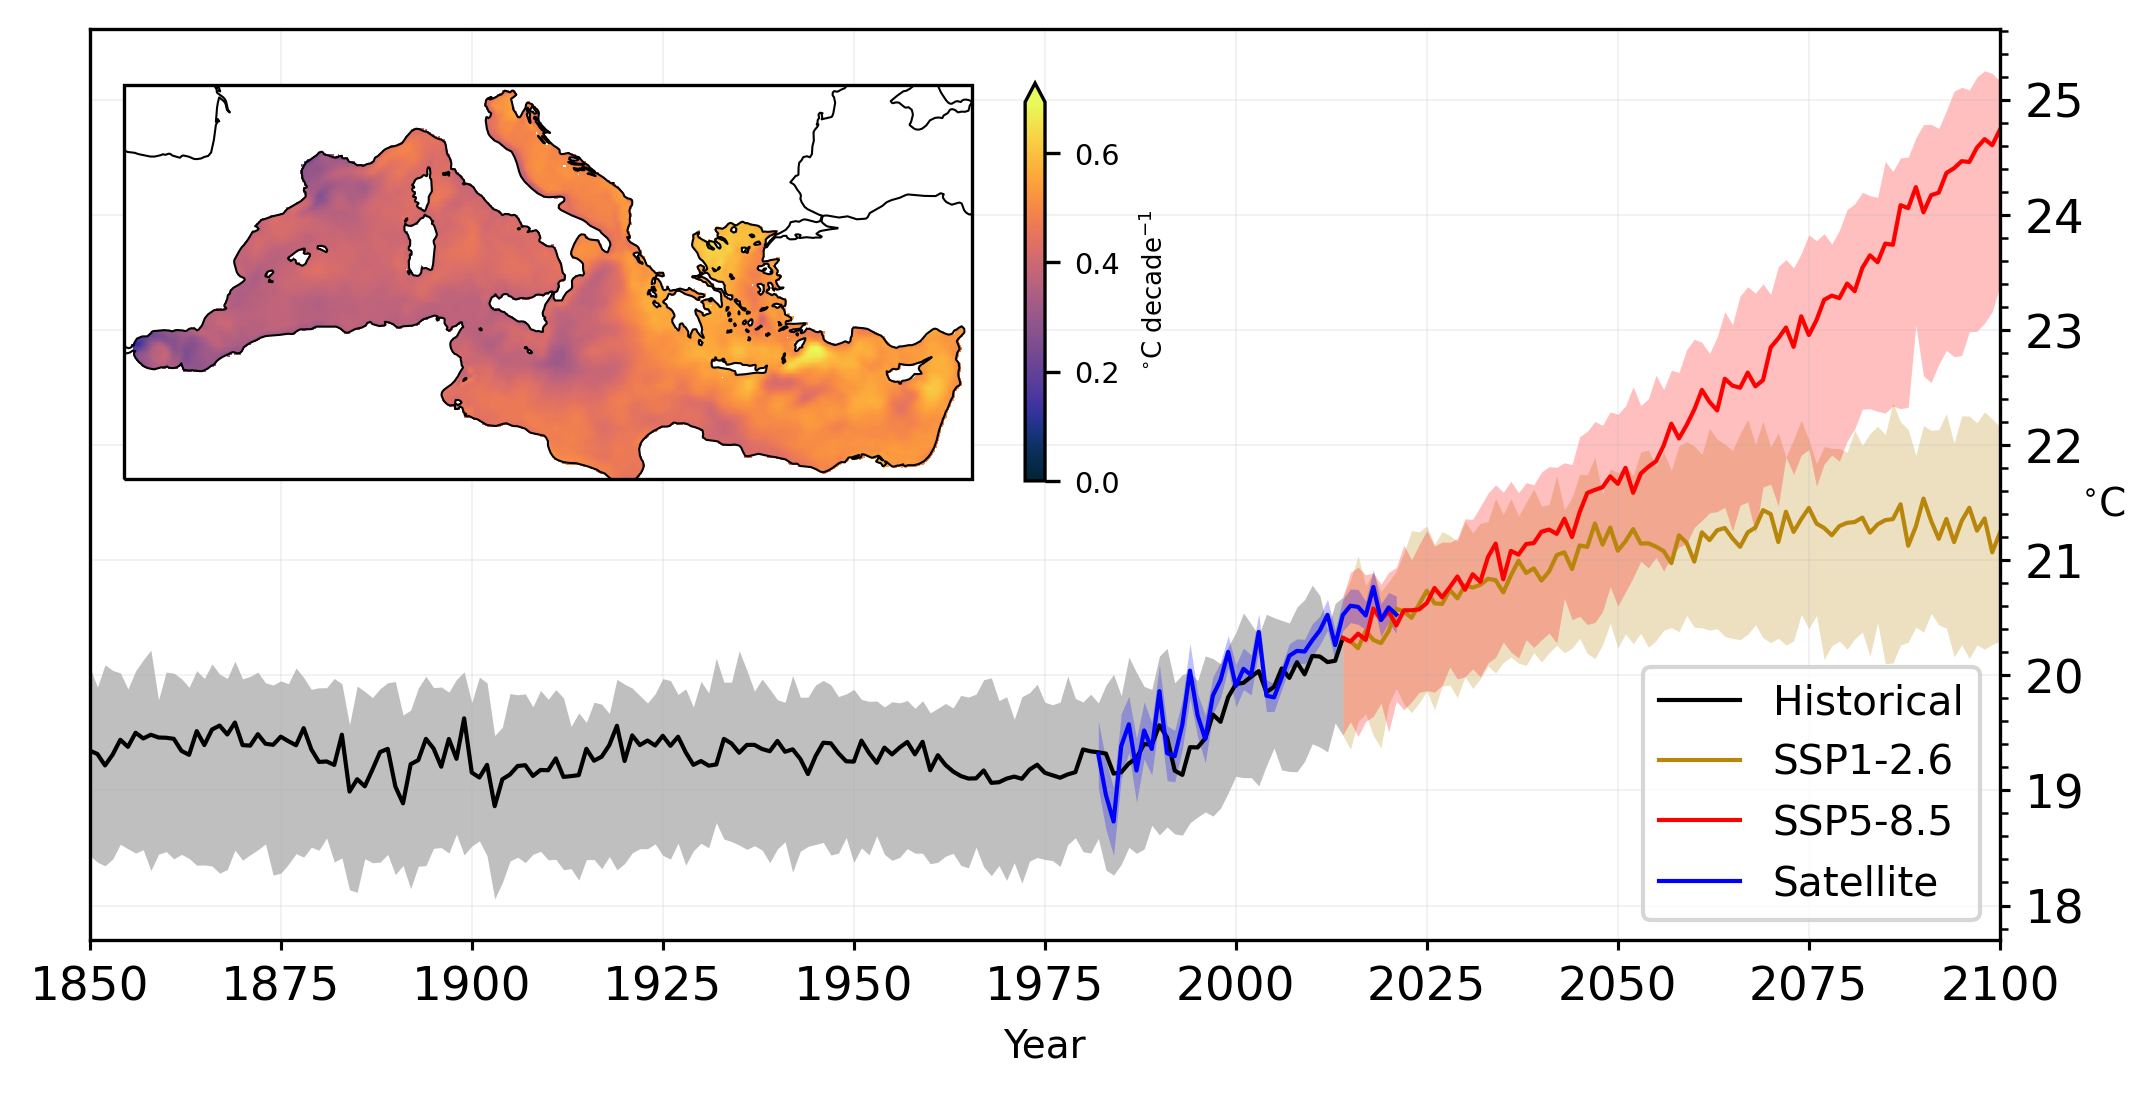

In [6]:
subplots = (1, 1)
fig, ax, fs, text_size = plot_utils.initialize_figure(
    ratio=2, subplots=subplots, fig_size=25, text_size=1.5
)

cs = ["darkgoldenrod", "r", "b"]

ax[0][0].plot(
    range(1850, 2014 + 1),
    percentiles["historical"][pctls[1]],
    color="k",
    lw=fs * 0.2,
    label="Historical",
)
ax[0][0].plot(
    range(2014, 2100 + 1),
    percentiles["ssp126"][pctls[1]],
    color=cs[0],
    lw=fs * 0.2,
    label="SSP1-2.6",
)
ax[0][0].plot(
    range(2014, 2100 + 1),
    percentiles["ssp585"][pctls[1]],
    color=cs[1],
    lw=fs * 0.2,
    label="SSP5-8.5",
)

alpha = 0.25

ax[0][0].fill_between(
    range(1850, 2014 + 1),
    percentiles["historical"][pctls[0]],
    percentiles["historical"][pctls[2]],
    color="k",
    alpha=alpha,
    lw=0,
)
ax[0][0].fill_between(
    range(2014, 2100 + 1),
    percentiles["ssp126"][pctls[0]],
    percentiles["ssp126"][pctls[2]],
    color=cs[0],
    alpha=alpha,
    lw=0,
)
ax[0][0].fill_between(
    range(2014, 2100 + 1),
    percentiles["ssp585"][pctls[0]],
    percentiles["ssp585"][pctls[2]],
    color=cs[1],
    alpha=alpha,
    lw=0,
)


ds_ts['sst'].plot(ax=ax[0][0], color=cs[2], lw=fs * 0.2, label='Satellite')
ax[0][0].fill_between(
    range(1982, 2021 + 1),
    ds_ts['sst_plus_error'],
    ds_ts['sst_minus_error'],
    color=cs[2],
    alpha=alpha,
    lw=0,
)


scale = 1.25
ax[0][0].set_xlim(1850, 2100)
ax[0][0].set_xticks(range(1850, 2100 + 1, 25))
ax[0][0].yaxis.tick_right()
ax[0][0].yaxis.set_label_position("right")
ax[0][0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0][0].set_ylabel("$^\circ \!$C", size=scale * text_size * fs, rotation=0)
ax[0][0].set_xlabel("Year", size=scale * text_size * fs, rotation=0)

plt.legend(loc='lower right', fontsize=1.3*text_size * fs)

extent = [
    float(ds_trend.lon.min()-0.5),
    float(ds_trend.lon.max()+0.5),
    float(ds_trend.lat.min()-0),
    float(ds_trend.lat.max()+0.2),
]


ax_map = fig.add_axes([0.05, 0.5, 0.5, 0.5], projection=ccrs.Mercator())
ax_map.set_extent(extent, crs=ccrs.PlateCarree())
ax_map.coastlines(linewidth=fs * 0.1)
im = ds_trend.plot(
    ax=ax_map,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.thermal,
    vmin=0,
    # vmax=0.0025,
    add_colorbar=False,
)

cbar = fig.colorbar(im, orientation="vertical", extend='max', shrink=0.75)
cbar.ax.tick_params(labelsize=scale*fs*1.1)
cbar.set_label("$^\circ \!$C decade$^{-1}$", fontsize=fs*scale, labelpad=fs)

ax_map.set_title('')

fig_fold = '../../figures/'
plt.savefig(
    f"{fig_fold}/fig_1.jpeg",
    bbox_inches="tight",
    dpi=300,
)
